In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from os.path import join as pjoin
# hilber transform
from scipy.signal import hilbert
import scipy
from scipy import signal
from scipy.stats import entropy

In [7]:
# conduct signal downsample first
def down_sample(data, fs, new_fs):
    new_data = scipy.signal.decimate(data, int(fs/new_fs), axis=0, zero_phase=True)
    return new_data

# generate a sos bandpass filter function
def butter_bandpass(lowcut, highcut, fs, data, order=5):
    nyq = 0.5 * fs # nyquist frequency
    low = lowcut / nyq
    high = highcut / nyq
    sos = signal.butter(order, [low, high], analog=False, btype="band", output="sos")
    filtered_signal = signal.sosfiltfilt(sos, data)
    return filtered_signal

def rose_plot(ax, angles, bins=16, density=None, offset=0, lab_unit="degrees",
              start_zero=False, **param_dict):
    """
    Plot polar histogram of angles on ax. ax must have been created using
    subplot_kw=dict(projection='polar'). Angles are expected in radians.
    """
    # Wrap angles to [-pi, pi)
    angles = (angles + np.pi) % (2*np.pi) - np.pi

    # Set bins symetrically around zero
    if start_zero:
        # To have a bin edge at zero use an even number of bins
        if bins % 2:
            bins += 1
        bins = np.linspace(-np.pi, np.pi, num=bins+1)

    # Bin data and record counts
    count, bin = np.histogram(angles, bins=bins)

    # Compute width of each bin
    widths = np.diff(bin)

    # By default plot density (frequency potentially misleading)
    if density is None or density is True:
        # Area to assign each bin
        area = count / angles.size
        # Calculate corresponding bin radius
        radius = (area / np.pi)**.5
    else:
        radius = count

    # Plot data on ax
    ax.bar(bin[:-1], radius, zorder=1, align='edge', width=widths,
           edgecolor='C0', fill=False, linewidth=1)

    # Set the direction of the zero angle
    ax.set_theta_offset(offset)

    # Remove ylabels, they are mostly obstructive and not informative
    ax.set_yticks([])

    if lab_unit == "radians":
        label = ['$0$', r'$\pi/4$', r'$\pi/2$', r'$3\pi/4$',
                  r'$\pi$', r'$5\pi/4$', r'$3\pi/2$', r'$7\pi/4$']
        ax.set_xticklabels(label)


In [8]:
def PAC(filtered_high, filtered_low):
    # Compute Hilbert transform to get analytic signals
    hilb_low_freq = hilbert(filtered_low)
    hilb_high_freq = hilbert(filtered_high)
    # Compute phase and amplitude time series
    phase_low_freq = np.angle(hilb_low_freq)
    amplitude_high_freq = np.abs(hilb_high_freq)
    # Phase binning (e.g., 18 bins for 20-degree increments)
    num_bins = 18
    phase_bins = np.linspace(-np.pi, np.pi, num_bins + 1)

    # Compute mean amplitude for each phase bin
    mean_amplitude_in_bin = np.zeros(num_bins)
    for i in range(num_bins):
        indices_in_bin = np.where((phase_low_freq >= phase_bins[i]) & (phase_low_freq < phase_bins[i + 1]))
        mean_amplitude_in_bin[i] = np.mean(amplitude_high_freq[indices_in_bin])
        # Compute mean amplitude across all phase bins
    # Normalize 
    mean_amplitude_in_bin /= np.sum(mean_amplitude_in_bin)
    
    # Compute modulation index
    mi = entropy(mean_amplitude_in_bin, base=2) / np.log(num_bins) 
    
    return mi


<Axes: xlabel='group', ylabel='plv'>

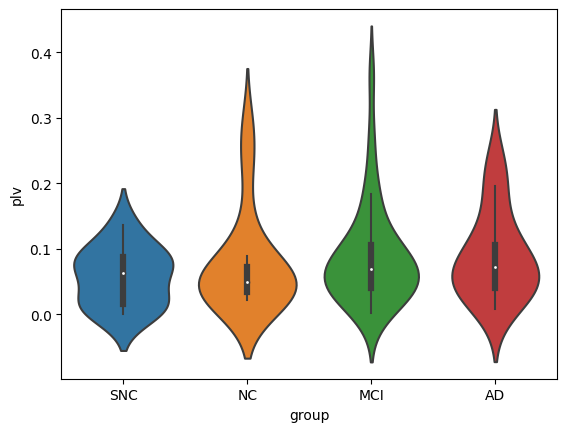

In [18]:
basedir = "/Users/yilewang/Documents/"
only_gc = pjoin(basedir, "local_inhibition_only_gc")
# read mega data
mega_data = pd.read_excel('/Users/yilewang/workspaces/data4project/mega_table.xlsx', sheet_name='tvb_parameters')

# Sampling rate
fs = 81920.0
 
node_names = ['aCNG-L', 'aCNG-R','mCNG-L','mCNG-R',
              'pCNG-L','pCNG-R', 'HIP-L','HIP-R','PHG-L',
              'PHG-R','AMY-L','AMY-R', 'sTEMp-L','sTEMP-R',
              'mTEMp-L','mTEMp-R']

df_mean = pd.DataFrame(columns=['group', 'caseid', 'Gc', 'mi'])

for gr, ca, gc in zip(mega_data.group, mega_data.caseid, mega_data.Gc):
    sample_data = np.load(pjoin(only_gc,gr, f"{ca}_{gc}.npy"))
    pCNG_L = sample_data[:,0,4,0]
    pCNG_R = sample_data[:,0,5,0]
    # pCNG_L_down = down_sample(pCNG_L, fs, 8192)
    # pCNG_R_down = down_sample(pCNG_R, fs, 8192)
    pCNG_L_theta= butter_bandpass(3, 8, 81920, pCNG_L)
    pCNG_R_theta= butter_bandpass(3, 8, 81920, pCNG_R)

    pCNG_L_gamma = butter_bandpass(30, 80, 81920, pCNG_L)
    pCNG_R_gamma = butter_bandpass(30, 80, 81920, pCNG_R)


    # small test
    # amplitude = np.abs(hilbert(pCNG_L_gamma))
    # figure = plt.figure(figsize=(10, 5))
    # plt.plot(amplitude[8192:81920])
    # plt.plot(pCNG_L_gamma[8192:81920])
    # plt.title(f"{gr}_{ca}_{gc}")
    # plt.show()

    # hilbert transform
    pCNG_L_theta_hilbert = hilbert(pCNG_L_theta)
    pCNG_R_theta_hilbert = hilbert(pCNG_R_theta)
    pCNG_L_gamma_hilbert = hilbert(pCNG_L_gamma)
    pCNG_R_gamma_hilbert = hilbert(pCNG_R_gamma)


    pCNG_L_theta_hilbert_angle = np.angle(pCNG_L_theta_hilbert)
    pCNG_R_theta_hilbert_angle = np.angle(pCNG_R_theta_hilbert)
    pCNG_L_gamma_hilbert_angle = np.angle(pCNG_L_gamma_hilbert)
    pCNG_R_gamma_hilbert_angle = np.angle(pCNG_R_gamma_hilbert)


    # Compute phase difference
    phase_diff = np.angle(np.exp(1j * (pCNG_R_gamma_hilbert_angle - pCNG_L_gamma_hilbert_angle)))

    # Compute phase locking value (PLV)
    plv = np.abs(np.mean(np.exp(1j * phase_diff)))

    # Compute phase amplitude coupling (PAC)
    mi_L = PAC(pCNG_L_theta, pCNG_L_gamma)
    mi_R = PAC(pCNG_R_theta, pCNG_R_gamma)


    phase_difference = pCNG_R_theta_hilbert_angle - pCNG_L_theta_hilbert_angle
    # cross correlation between pCNG_L and pCNG_R

    df_mean = pd.concat([df_mean, pd.DataFrame({'group': [gr], 'caseid': [ca], 'mi':[np.abs(mi_L-mi_R)], 'Gc': [gc], 'mi_L': [mi_L], 'mi_R': [mi_R], 'plv': [plv]})])

    # df_mean = pd.concat([df_mean, pd.DataFrame({'group': [gr], 'caseid': [ca], 'Gc': [gc], 'PAC_mean_L': [np.mean(mean_amplitude_in_bi)], 'PAC_mean_R': [np.mean(mean_amplitude_in_bin_R)], 'PAC_mean': [np.mean([np.abs(np.mean(mean_amplitude_in_bin_L) - np.mean(mean_amplitude_in_bin_R))])], 'PLV': [plv]})])
    # # Visualise with polar histogram
    # fig = plt.figure(figsize=(10, 5))
    # ax1 = plt.subplot(121, projection='polar')
    # ax2 = plt.subplot(122)
    # fig, ax = plt.subplots(subplot_kw=dict(projection='polar'), figsize=(6,6))
    # rose_plot(ax1, phase_difference, bins=50)
    # ax2.plot(pCNG_L_gamma_hilbert_angle[8192:81920], label="pCNG_L")
    # ax2.plot(pCNG_R_gamma_hilbert_angle[8192:81920], label="pCNG_R")
    # ax2.plot(pCNG_L[8192:81920], label="pCNG_L_raw")
    # ax2.plot(pCNG_R[8192:81920], label="pCNG_R_raw")
    # ax2.legend()
    # fig.tight_layout()
    # plt.title(f"{gr}_{ca}_{gc}")
    # plt.show()
# save the dataframe
# df_mean.to_csv("./asymmetry_phase.csv", index=False)
sns.violinplot(x="group", y="plv", data=df_mean)

<Axes: xlabel='group', ylabel='plv'>

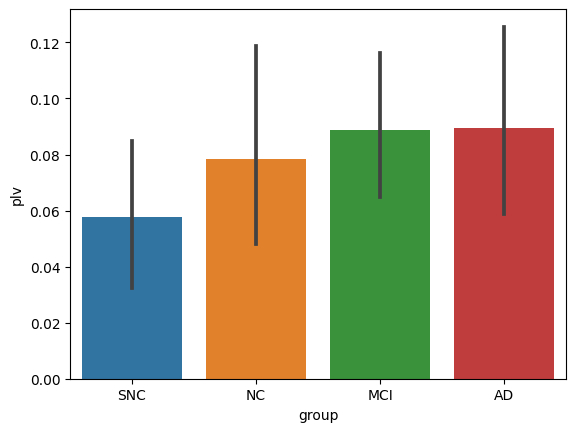

In [19]:
sns.barplot(x="group", y="plv", data=df_mean)
# sns.barplot(x="group", y="mi", data=df_mean)

In [ ]:
basedir = "/Volumes/lab4data"
only_gc = pjoin(basedir, "local_inhibition_only_gc")
# read mega data
mega_data = pd.read_excel('/Users/yilewang/workspaces/data4project/mega_table.xlsx', sheet_name='tvb_parameters')

# Sampling rate
fs = 81920.0
 
node_names = ['aCNG-L', 'aCNG-R','mCNG-L','mCNG-R',
              'pCNG-L','pCNG-R', 'HIP-L','HIP-R','PHG-L',
              'PHG-R','AMY-L','AMY-R', 'sTEMp-L','sTEMP-R',
              'mTEMp-L','mTEMp-R']
# Quick plot to see the trace/s
gr, ca, gc  = 'NC', '0316A', '0.017'

sample_data = np.load(pjoin(only_gc,gr, f"{ca}_{gc}.npy"))
plt.figure(figsize=(12,4), dpi=300)
# for index, i in enumerate(node_names):
#     plt.plot(sample_data[:,0,index,0])
time = np.arange(0.1, 1, 1/81920)
plt.plot( time ,sample_data[8192:81920,0,4,0], label='pCNG-L')
plt.plot(time,sample_data[8192:81920,0,5,0], label='pCNG-R')
plt.xlabel('Time (s)')
plt.ylabel('Magnitude')
plt.legend()
# hide top and right frame
plt.gca().spines['top'].set_visible(False)

pCNG_L = sample_data[:,0,4,0]
pCNG_R = sample_data[:,0,5,0]

In [ ]:
pCNG_L_down = down_sample(pCNG_L, fs, 8192)
pCNG_R_down = down_sample(pCNG_R, fs, 8192)
pCNG_L_theta= butter_bandpass(3, 10, 8192, pCNG_L_down)
pCNG_R_theta= butter_bandpass(3, 10, 8192, pCNG_R_down)

# hilbert transform
pCNG_L_theta_hilbert = hilbert(pCNG_L_theta)
pCNG_R_theta_hilbert = hilbert(pCNG_R_theta)

plt.figure(figsize=(12,4), dpi=300)
plt.plot(pCNG_L_theta, label='pCNG-L')
plt.plot(pCNG_R_theta, label='pCNG-R')
plt.plot(pCNG_L_theta_hilbert.imag, label='pCNG-L.imag')
plt.plot(pCNG_R_theta_hilbert.imag, label='pCNG-R.imag')

plt.xlabel('Time (s)')
plt.ylabel('Magnitude')
plt.legend()
# hide top and right frame
plt.gca().spines['top'].set_visible(False)
plt.show()


In [ ]:
figure = plt.figure(figsize=(12,4), dpi=300)
plt.plot( np.angle(pCNG_L_theta_hilbert), label='pCNG-L.ang')
plt.plot( np.angle(pCNG_R_theta_hilbert), label='pCNG-R.ang')
plt.xlabel('Time (s)')
plt.ylabel('Phase (rad)')
plt.legend()
# hide top and right frame
plt.gca().spines['top'].set_visible(False)
plt.show()

print(np.angle(pCNG_L_theta_hilbert, deg=True))

In [ ]:
# Plot histogram of phase difference
plt.figure(figsize=(12,4), dpi=300)
plt.hist(np.angle(pCNG_L_theta_hilbert, deg=True)-np.angle(pCNG_R_theta_hilbert, deg=True), bins=50)
plt.xlabel('Phase difference (rad)')
plt.ylabel('Count')
# hide top and right frame
plt.gca().spines['top'].set_visible(False)
plt.show()

In [ ]:
pCNG_L_theta_hilbert_angle = np.angle(pCNG_L_theta_hilbert)
pCNG_R_theta_hilbert_angle = np.angle(pCNG_R_theta_hilbert)

phase_difference = pCNG_L_theta_hilbert_angle - pCNG_R_theta_hilbert_angle


# Visualise with polar histogram
fig, ax = plt.subplots(subplot_kw=dict(projection='polar'), figsize=(6,6))
rose_plot(ax, phase_difference, bins=50)
fig.tight_layout()